## Produce the json file listing all profiles in MED region

In [2]:
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from datetime import date
import io
import json


In [8]:
ds=xr.open_dataset('/gpfsstore/rech/egi/commun/MEDWEST60/MEDWEST60-I/MEDWEST60_coordinates_v3.nc4')
lat=ds.nav_lat
lon=ds.nav_lon
latmin,latmax,lonmin,lonmax=(lat.min(),lat.max(),lon.min(),lon.max())
print(latmin,latmax,lonmin,lonmax)

<xarray.DataArray 'nav_lat' ()>
array(34.84750366) <xarray.DataArray 'nav_lat' ()>
array(45.13545609) <xarray.DataArray 'nav_lon' ()>
array(-5.68308401) <xarray.DataArray 'nav_lon' ()>
array(9.59771824)


In [3]:
jsonfile='MEDWEST60_y2010m01d01-y2010m09d30.json'


In [4]:
datemin=datetime.date(2010,1,1)
datemax=datetime.date(2010,9,30)


In [12]:
def select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile):
    ''' Identify all the EN4 profiles that fall within the selected zone and period
    '''
    # where EN4 is stored on cal1 from lgge194
    diren4="/gpfswork/rech/egi/rote001/EN4/"
    
    # create a list of daily dates between datemin and datemax
    def date_range(start, end):
        r = (end+datetime.timedelta(days=1)-start).days
        return [start+datetime.timedelta(days=i) for i in range(r)]
    dateList = date_range(datemin, datemax) # list of days between datemin and datemax

    # make a list of the EN4 daily files that corresponds all dates in dateList
    list_filesEN4=[]
    for date in dateList:
        year=date.year
        month=date.month
        day=date.day
        mm="{:02d}".format(month) #month on 2 digits
        dd="{:02d}".format(day) # day on 2 digits
        list_filesEN4.append(str(year)+str(mm)+str(dd)+'_prof.nc')
                          
                          
    # convert datemin and datemax to a number of seconds since 1958
    datetmin=pd.to_datetime(datemin)
    datetmax=pd.to_datetime(datemax)
    ttmin=datetime.datetime(int(datetmin.strftime('%Y')),int(datetmin.strftime('%m')),
                            int(datetmin.strftime('%d')),int(datetmin.strftime('%H')),int(datetmin.strftime('%M')))
    ttmax=datetime.datetime(int(datetmax.strftime('%Y')),int(datetmax.strftime('%m')),
                            int(datetmax.strftime('%d')),int(datetmax.strftime('%H')),int(datetmax.strftime('%M')))
    tsecmin=(ttmin-datetime.datetime(1958,1,1,0,0)).total_seconds()
    tsecmax=(ttmax-datetime.datetime(1958,1,1,0,0)).total_seconds()

    # for each EN4 daily file selected, find the profiles that are in the [lonmin,lonmax,latmin,latmax] region
    for f in np.arange(len(list_filesEN4)):
        fileEN4=list_filesEN4[f]
        print('Processing '+str(fileEN4))
        tfileEN4=diren4+fileEN4
        #open the file and read the infos on latitude,lon,date and reference, all 1D variables
        dsen4=xr.open_dataset(tfileEN4)
        laten4=dsen4['LATITUDE']
        lonen4=dsen4['LONGITUDE']
        dayen4=dsen4['JULD']
        refen4=dsen4['DC_REFERENCE']
        #find the indices for which the location is in the good region
        indz=np.where((lonmin.values<lonen4.values)&(lonen4.values<lonmax.values)&(latmin.values<laten4.values)&
                      (laten4.values<latmax.values))
        prof_zone=[]
        tsecen4z=[]
        
        #for each profile selected, check for the date exactly
        for ref in np.arange(len(indz[0])):
            #convert date into seconds from 1958
            dateen4= pd.to_datetime(str(dayen4[indz[0][ref]].values))
            ten4 = datetime.datetime(int(dateen4.strftime('%Y')),int(dateen4.strftime('%m')),
                                     int(dateen4.strftime('%d')),int(dateen4.strftime('%H')),int(dateen4.strftime('%M')))
            tsecen4=(ten4-datetime.datetime(1958,1,1,0,0)).total_seconds()
            #keep only profiles with good date
            if (tsecen4 < tsecmax) & (tsecen4 > tsecmin):
                prof_zone.append(indz[0][ref])
                tsecen4z.append(tsecen4)
                
        #for the selection of profiles, write infos in a dict
        for ref in np.arange(len(prof_zone)):
            if 'dictyml' in locals():
                up={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),
                                                        'file':fileEN4,'profile no':int(prof_zone[ref]),
                                                        'latitude':float(laten4[prof_zone[ref]].values),
                                                        'longitude':float(lonen4[prof_zone[ref]].values),
                                                        'date':str(dayen4[prof_zone[ref]].values)}}
                dictyml.update(up)
            else:
                dictyml={str(refen4[prof_zone[ref]].values):{'reference':str(refen4[prof_zone[ref]].values),
                                                             'file':fileEN4,'profile no':int(prof_zone[ref]),
                                                             'latitude':float(laten4[prof_zone[ref]].values),
                                                             'longitude':float(lonen4[prof_zone[ref]].values),
                                                             'date':str(dayen4[prof_zone[ref]].values)}}

        #write dict in a json file           
    with io.open(jsonfile, 'w', encoding='utf8') as outfile:
        outfile.write(str(json.dumps(dictyml, sort_keys=True,indent=4, separators=(',', ': '))))



In [13]:
select_profiles(latmin,latmax,lonmin,lonmax,datemin,datemax,jsonfile)

Processing 20100101_prof.nc
Processing 20100102_prof.nc
Processing 20100103_prof.nc
Processing 20100104_prof.nc
Processing 20100105_prof.nc
Processing 20100106_prof.nc
Processing 20100107_prof.nc
Processing 20100108_prof.nc
Processing 20100109_prof.nc
Processing 20100110_prof.nc
Processing 20100111_prof.nc
Processing 20100112_prof.nc
Processing 20100113_prof.nc
Processing 20100114_prof.nc
Processing 20100115_prof.nc
Processing 20100116_prof.nc
Processing 20100117_prof.nc
Processing 20100118_prof.nc
Processing 20100119_prof.nc
Processing 20100120_prof.nc
Processing 20100121_prof.nc
Processing 20100122_prof.nc
Processing 20100123_prof.nc
Processing 20100124_prof.nc
Processing 20100125_prof.nc
Processing 20100126_prof.nc
Processing 20100127_prof.nc
Processing 20100128_prof.nc
Processing 20100129_prof.nc
Processing 20100130_prof.nc
Processing 20100131_prof.nc
Processing 20100201_prof.nc
Processing 20100202_prof.nc
Processing 20100203_prof.nc
Processing 20100204_prof.nc
Processing 20100205_

## Plot the locations of all profiles

In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [15]:
    sourcefile=open(jsonfile,'rU',encoding='utf-8')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)
    list_profiles=infos.keys()

    all_lat=np.zeros((nb_profilesEN4))
    all_lon=np.zeros((nb_profilesEN4))
    
    for prof in np.arange(nb_profilesEN4):
        reference =  str(list(list_profiles)[prof])
        lat_prof = infos[reference]['latitude']
        lon_prof = infos[reference]['longitude']
        all_lat[prof]=lat_prof
        all_lon[prof]=lon_prof


/gpfslocalsup/pub/anaconda-py3/2020.02/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [16]:
len(all_lon)

307

In [18]:
def map_profiles_from_jsonfile(all_lat,all_lon):
    


    fig=plt.figure(figsize=(20,15))
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((lonmin, lonmax, latmin, latmax))
    ax.coastlines(resolution="10m")
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.scatter(all_lon, all_lat, c='g', linewidth='0', s=18);
    plt.title('EN4 profiles in MEDWEST60 y2010m01d01-y2010m09d30', size=20);
    plt.savefig('profiles_MEDWEST60_y2010m01d01-y2010m09d30.png')


/gpfslocalsup/pub/anaconda-py3/2020.02/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/10m/physical/ne_10m_coastline.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


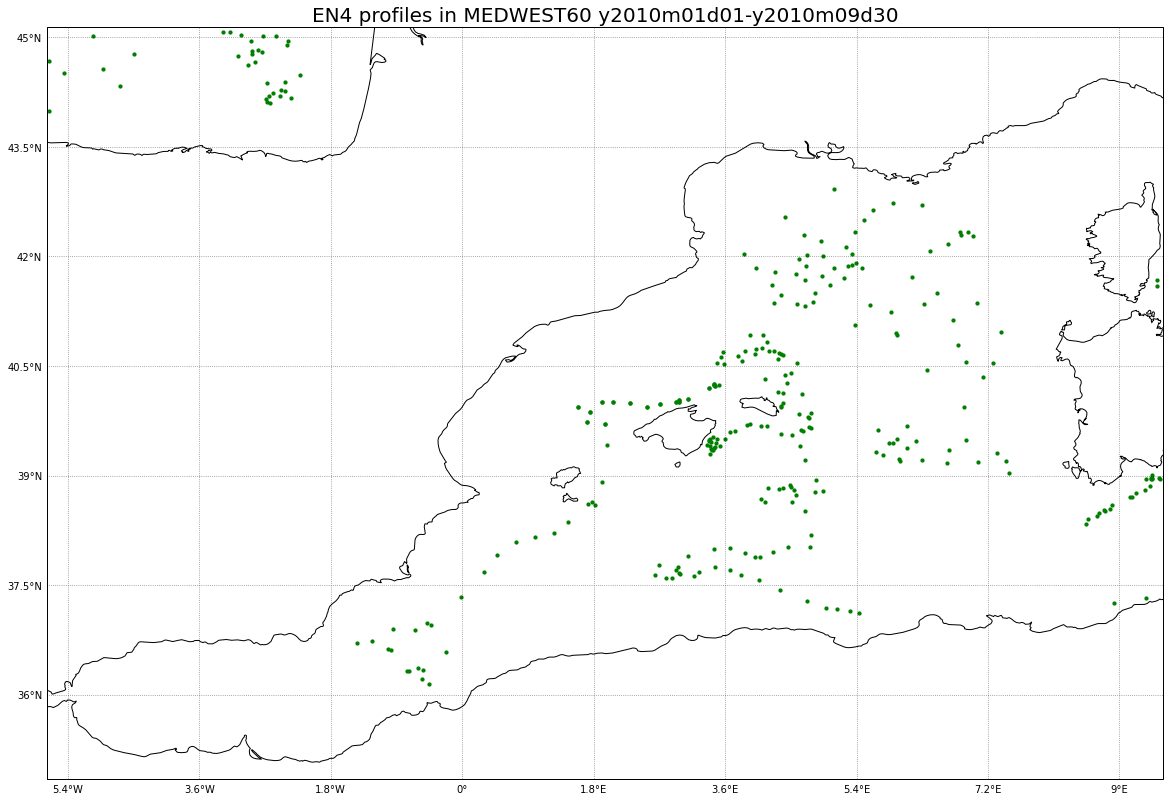

In [19]:
map_profiles_from_jsonfile(all_lat,all_lon)